In [1]:
import sys
# sys.path.insert(0, '/home/gfzg/workspace/数据下载/Wind/Packages')
# sys.path.insert(0, '/home/gfzg/workspace/债券分析/Packages')
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
from importlib import reload
import re
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import math
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import janitor   
# 需要找到C:\Users\lenovo\anaconda3\Lib\site-packages路径下的janitor.py 
# 把ConfigParser改成configparse
# from werkzeug.contrib.fixers import ProxyFix 改成 from werkzeug.middleware.proxy_fix import ProxyFix
import time
from progressbar import progressbar as pbar # 该用pg进度条了
from tabulate import tabulate
# 核心包
# import Wind
import Bonder 
# from Bonder import * 
import Selector
import dolphindb as ddb

import matplotlib as mpl
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

### 字段说明

### 筛选方式说明

In [2]:
# 筛选最外层由[]包裹, 内部元素由 and 连接：
# 元素可以是以下两种：

#  1. (字段,逻辑符,值): 
# 逻辑符 支持 "==","!=",">=","<=",">","<","isin","isna","isnotna"
# 当逻辑符是isin时 值为 []
# 当逻辑符时isna或isnotna时 值可任意输入 一般输入''

# 2. [(字段,逻辑符,值),...,(字段,逻辑符,值)]: 
# 内部(字段,逻辑符,值)间由 or 连接

# BondStaticFilters = [
#     ('isPerpetualBonds','==',0),
#     [('CNBD_HIDDEN_CREDITRATING','==','AAA'),('CNBD_HIDDEN_CREDITRATING','==','AA+')],
# ]
# BondStaticFilters = [
#     ('isPerpetualBonds','==',0),
#     ('CNBD_HIDDEN_CREDITRATING','isin',['AAA','AA+']),
# ]
# 如BondStaticFilters表达为 不是永续债 且 （债券等级AAA 或 债券等级AA+）的债券

In [3]:
# reload(Bonder)    # 重新载入之前载入的模块
# 初始化债券分析框架 Bonder
BondAnalyzer = Bonder.BondAnalyzer()

# 导入3张表
# STATIC
# BONDS
# FILLED_GUOKAI 见最上方国开债部分

# 静态筛选 
BondStaticFilters = [
    ('suffix','isin',['IB','SH','SZ']), # 默认选择标准代码
    ('CATEGORY1','==','信用债'),  # 默认选择信用债，不含利率债、同业存单、ABS、可转债
    ('isPerpetualBonds','==',0),  # 剔除：永续债
    ('IS_FAILURE','==',0)        # 剔除：发行失败
#     ('B_INFO_GUARTYPE','isna','') # 剔除：附带担保债
]
# 动态筛选
# 只考虑对应计算节点剩余期 限在 10 年以内个券
# 0. 仅保留 IB SH SZ债券
BondDynamicFilters = [
    ('B_ANAL_MATU_CNBD','<=', 10)
]
# 生成债券池
dataConfig = {
    'StaticPath': './Results/STATIC.parquet',
    'BondsPath': './Results/BONDS.parquet', 
    'FilledGuokaiPath': './Results/FILLED_GUOKAI.parquet',
    'BondStaticFilters': BondStaticFilters,
    'BondDynamicFilters': BondDynamicFilters,
}
df = BondAnalyzer.dataCenter(dataConfig)

数据筛选中...请等待
筛选结果数据量： 14039
STATIC: suffix isin ['IB', 'SH', 'SZ'] and CATEGORY1 == 信用债 and isPerpetualBonds == 0 and IS_FAILURE == 0
数据筛选中...请等待
筛选结果数据量： 11014822
BONDS: B_ANAL_MATU_CNBD <= 10
信用计算利差中
数据处理完成


In [4]:
STATIC = pd.read_parquet('./Results/STATIC.parquet')
# STATIC.to_csv('./Results/STATIC.csv', encoding='gbk')
STATIC.drop('B_INFO_ISSUERCODE', inplace=True, axis=1)
# STATIC

In [5]:
BONDS = pd.read_parquet('./Results/BONDS.parquet')
# BONDS.to_csv('./Results/BONDS.csv',encoding='gbk')
BONDS

,S_INFO_WINDCODE,TRADE_DT,B_ANAL_MATU_CNBD,B_ANAL_YIELD_CNBD,B_ANAL_RESIDUALPRI,CNBD_HIDDEN_CREDITRATING,B_INFO_CREDITRATING_BOND,B_INFO_ISSUERCODE,B_INFO_CREDITRATING_ISSUER,B_ANAL_MATU_CNBD_YEAR
0,010221.IB,20220104,10.0219,3.2253,100.0,None,None,2002700,AAA,11.0
1,010221.IB,20220105,10.0192,3.2299,100.0,None,None,2002700,AAA,11.0
2,010221.IB,20220106,10.0164,3.2398,100.0,None,None,2002700,AAA,11.0
3,010221.IB,20220107,10.0137,3.2426,100.0,None,None,2002700,AAA,11.0
4,010221.IB,20220110,10.0055,3.2352,100.0,None,None,2002700,AAA,11.0
...,...,...,...,...,...,...,...,...,...,...
14886336,809106.IB,20230915,4.9891,2.5985,100.0,None,AAA,0LEB921B54,None,5.0
14886337,809106.IB,20230918,4.9809,2.6079,100.0,None,AAA,0LEB921B54,None,5.0
14886338,809106.IB,20230919,4.9781,2.6183,100.0,None,AAA,0LEB921B54,None,5.0
14886339,809106.IB,20230920,4.9754,2.6095,100.0,None,AAA,0LEB921B54,None,5.0


In [6]:
FILLED_GUOKAI = pd.read_parquet('./Results/FILLED_GUOKAI.parquet')
# FILLED_GUOKAI.to_csv('./Results/FILLED_GUOKAI.csv',encoding='gbk')
# FILLED_GUOKAI

In [7]:
df

,S_INFO_WINDCODE,B_INFO_FULLNAME,B_INFO_ISSUER,B_INFO_CARRYDATE,B_INFO_MATURITYDATE,B_INFO_TERM_YEAR_,B_INFO_PAYMENTTYPE,S_INFO_EXCHMARKET,B_INFO_INTERESTFREQUENCY,IS_FAILURE,B_INFO_GUARTYPE,IS_CORPORATE_BOND,B_INFO_ISSUERTYPE,B_INFO_ISSUETYPE,suffix,S_INFO_INDUSTRYNAME_WindLevel1,S_INFO_INDUSTRYNAME_WindLevel2,CATEGORY1,CATEGORY2,CATEGORY3,isPerpetualBonds,isTier2CapitalBonds,BOND_TYPE,B_AGENCY_GUARANTORNATURE,S_INFO_COMPIND_NAME1,S_INFO_COMPIND_NAME2,S_INFO_COMPIND_NAME3,S_INFO_COMPIND_NAME4,PROVINCE,CITY,DISTRICT,AREA,ADMINISTRATIVE_LEVEL,IS_SUB,TRADE_DT,B_ANAL_MATU_CNBD,B_ANAL_YIELD_CNBD,B_ANAL_RESIDUALPRI,CNBD_HIDDEN_CREDITRATING,B_INFO_CREDITRATING_BOND,B_INFO_ISSUERCODE,B_INFO_CREDITRATING_ISSUER,B_ANAL_MATU_CNBD_YEAR,B_ANAL_YIELD_GUOKAI,CREDIT_SPREAD
0,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,20220104,0.57,2.6754,100.0,AAA,AAA,2002227,AAA,1.0,9.87239,-7.19699
1,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,20220105,0.57,2.6571,100.0,AAA,AAA,2002227,AAA,1.0,9.86199,-7.20489
2,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,20220106,0.56,2.6319,100.0,AAA,AAA,2002227,AAA,1.0,9.84668,-7.21478
3,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,20220107,0.56,2.6493,100.0,AAA,AAA,2002227,AAA,1.0,9.84458,-7.19528
4,078036.IB,2007年上海城市建设债券,上海城投(集团)有限公司,20070731,20220731,15.0,单利,NIB,每1年,0.0,507002000.0,0.0,企业,公募,IB,企业债,一般企业债,信用债,企业债,,0,0,城投债,地方国有企业,公用事业,公用事业Ⅱ,水务Ⅲ,水务,上海,上海市,,,直辖市,0.0,20220110,0.55,2.6501,100.0,AAA,AAA,2002227,AAA,1.0,9.84960,-7.19950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050222,2223004.IB,国联人寿保险股份有限公司2022年资本补充债券,国联人寿保险股份有限公司,20220324,20320324,10.0,单利,NIB,每1年,0.0,507002000.0,0.0,其它金融机构,公募,IB,金融债,保险公司债,信用债,金融债,保险公司债,0,0,金融债,地方国有企业,金融,保险Ⅱ,保险Ⅲ,人寿与健康保险,None,None,None,None,None,NaN,20230915,3.52,3.8859,100.0,AA-,AAA,UL3DUXx02g,AA,4.0,10.63222,-6.74632
1050223,2223004.IB,国联人寿保险股份有限公司2022年资本补充债券,国联人寿保险股份有限公司,20220324,20320324,10.0,单利,NIB,每1年,0.0,507002000.0,0.0,其它金融机构,公募,IB,金融债,保险公司债,信用债,金融债,保险公司债,0,0,金融债,地方国有企业,金融,保险Ⅱ,保险Ⅲ,人寿与健康保险,None,None,None,None,None,NaN,20230918,3.51,3.8789,100.0,AA-,AAA,UL3DUXx02g,AA,4.0,NaN,NaN
1050224,2223004.IB,国联人寿保险股份有限公司2022年资本补充债券,国联人寿保险股份有限公司,20220324,20320324,10.0,单利,NIB,每1年,0.0,507002000.0,0.0,其它金融机构,公募,IB,金融债,保险公司债,信用债,金融债,保险公司债,0,0,金融债,地方国有企业,金融,保险Ⅱ,保险Ⅲ,人寿与健康保险,None,None,None,None,None,NaN,20230919,3.51,3.8359,100.0,AA-,AAA,UL3DUXx02g,AA,4.0,NaN,NaN
1050225,2223004.IB,国联人寿保险股份有限公司2022年资本补充债券,国联人寿保险股份有限公司,20220324,20320324,10.0,单利,NIB,每1年,0.0,507002000.0,0.0,其它金融机构,公募,IB,金融债,保险公司债,信用债,金融债,保险公司债,0,0,金融债,地方国有企业,金融,保险Ⅱ,保险Ⅲ,人寿与健康保险,None,None,None,None,None,NaN,20230920,3.51,3.8434,100.0,AA-,AAA,UL3DUXx02g,AA,4.0,NaN,NaN


### 时序图像绘制

数据筛选中...请等待
筛选结果数据量： 100630


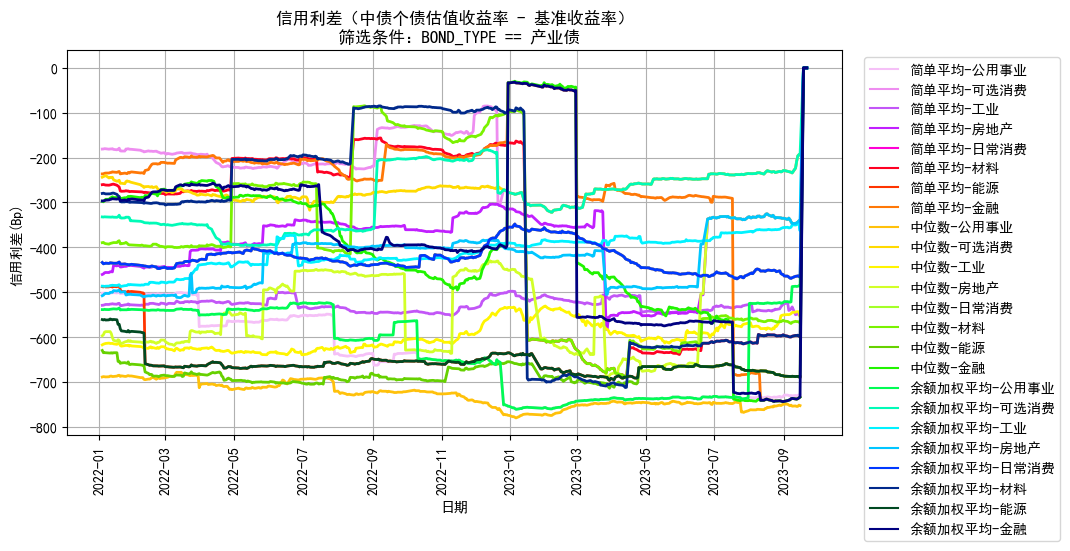

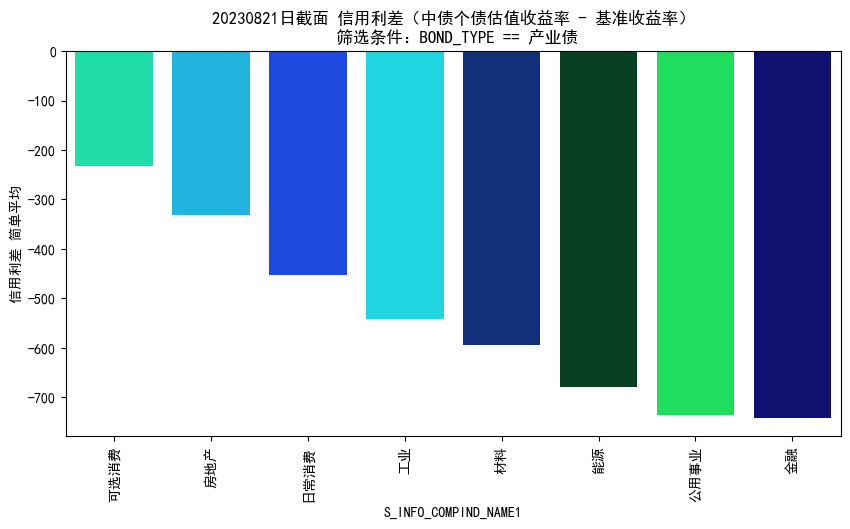

In [8]:
# 时序图像绘制
# 参数
division_label = 'S_INFO_COMPIND_NAME1' # 根据这个字段的类别画线
Filters = [
    ('BOND_TYPE','==','产业债'),
]
CrossSectionConfig = {
    'date':'20230821', # 截面日期   原本是20230921，但是数据都是0，所以改掉
    'plotCrossSection':True, # 是否绘制date时间的柱状截面图
}
# methods 0: 简单平均 1: 中位数 2: 剩余本金加权
BondAnalyzer.plotCreditSpread(
    data=df,
    filters=Filters,
    divisionLabel=division_label,
    methods=[0,1,2],
    config=CrossSectionConfig
)

### 个债预警

In [9]:
# Mac 3500个债 约90s Windows较慢 4mins30s
# 债券累计存续时常小于250天不预警
YIELD_CHANGE_PERIOD=7
QUANTILE=0.98
ROLLING_WINDOW=250
ALARM_PERIOD=20
alarmConfig = {
    'TODAY':'20230821' #扫描哪天的存续债
}
ALARMRES = BondAnalyzer.initBondAlarms(
    df,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, # 累计收益周期
    QUANTILE=QUANTILE, # 预警分位数
    ROLLING_WINDOW=ROLLING_WINDOW, # 历史分位窗口
    ALARM_PERIOD=ALARM_PERIOD, # 预警窗口
    config=alarmConfig
)

  0%|                                                                                 | 3/2527 [00:00<02:01, 20.83it/s]

开始检测最近20日出现超越7日累计估值收益变动的绝对值在历史250日内的0.98分位数的20230821债券


100%|██████████████████████████████████████████████████████████████████████████████| 2527/2527 [01:16<00:00, 33.04it/s]


In [10]:
# Mac 3500个债 约90s Windows较慢 4mins30s
# 债券累计存续时常小于250天不预警
YIELD_CHANGE_PERIOD=7
QUANTILE=0.98
ROLLING_WINDOW=250
ALARM_PERIOD=20
alarmConfig = {
    'TODAY':'20230821' #扫描哪天的存续债
}
ALARMRES = BondAnalyzer.initBondAlarms(
    df,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, # 累计收益周期
    QUANTILE=QUANTILE, # 预警分位数
    ROLLING_WINDOW=ROLLING_WINDOW, # 历史分位窗口
    ALARM_PERIOD=ALARM_PERIOD, # 预警窗口
    config=alarmConfig
)
df_alarmed_pos_bond = ALARMRES['df_alarmed_pos_bond']
df_alarmed_neg_bond = ALARMRES['df_alarmed_neg_bond']
alarmed_pos_bond_codes = ALARMRES['alarmed_pos_bond_codes']
alarmed_neg_bond_codes = ALARMRES['alarmed_neg_bond_codes']
ALARMED_POS_BONDS = ALARMRES['ALARMED_POS_BONDS']
ALARMED_NEG_BONDS = ALARMRES['ALARMED_NEG_BONDS']

  0%|                                                                                 | 3/2527 [00:00<01:40, 25.12it/s]

开始检测最近20日出现超越7日累计估值收益变动的绝对值在历史250日内的0.98分位数的20230821债券


100%|██████████████████████████████████████████████████████████████████████████████| 2527/2527 [01:17<00:00, 32.58it/s]


In [11]:
df_alarmed_pos_bond, df_alarmed_neg_bond # 最近突破日期在

(  S_INFO_WINDCODE    最近突破日期  突破时变化程度bp  绝对预警线bp
 0       152476.SH  20230807      56.77  48.8496
 1       152865.SH  20230807      57.26  55.4630
 2      2080133.IB  20230807      56.77  48.8496
 3      2180185.IB  20230807      57.26  55.4630
 4       152681.SH  20230731      51.77  50.0410
 5       152924.SH  20230731      49.96  48.2940
 6      2080396.IB  20230731      51.77  50.0410
 7      2180237.IB  20230731      49.96  48.2940,
    S_INFO_WINDCODE    最近突破日期  突破时变化程度bp   绝对预警线bp
 0        127586.SH  20230821    -385.28  205.8556
 1       1980009.IB  20230821    -110.00   74.8644
 2        139251.SH  20230821    -103.00   79.9780
 3        152077.SH  20230821    -110.00   74.8644
 4       1680412.IB  20230821    -103.00   79.9780
 5       1724020.IB  20230821    -385.28  205.8556
 6        152119.SH  20230817     -71.98   54.6828
 7       1780379.IB  20230817     -56.43   54.7986
 8        127715.SH  20230817     -56.43   54.7986
 9       1980040.IB  20230817     -71.98   54.68

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

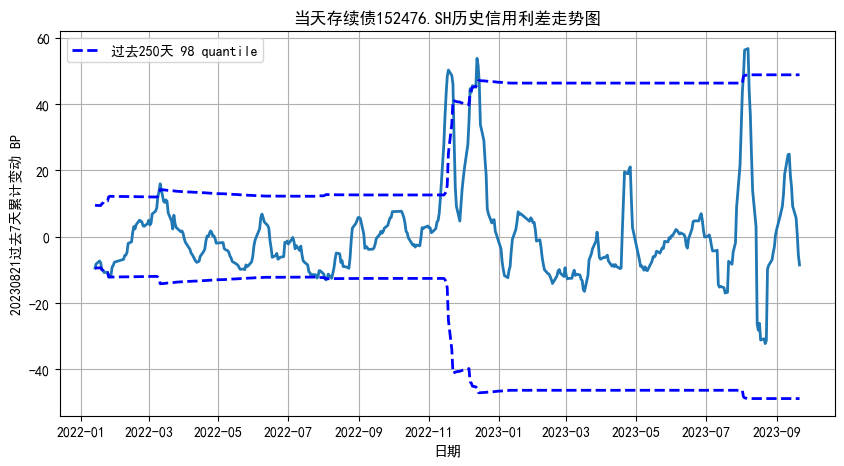

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

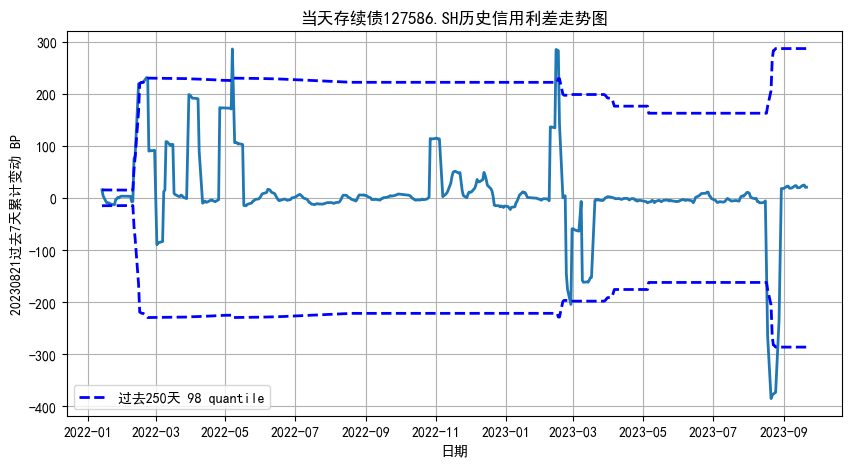

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.89it/s]

ALARM!!!


In [12]:
SHOW_POS_BONDS = list(ALARMED_POS_BONDS.index.unique())[:1]
SHOW_NEG_BONDS = list(ALARMED_NEG_BONDS.index.unique())[:1]
config = {
    'plot':True,
    'plot_abs':False,
}
POS_SUMMARY,_= BondAnalyzer.showSingleBond(
    data=ALARMED_POS_BONDS, 
    bond_codes=SHOW_POS_BONDS,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD, 
    QUANTILE=QUANTILE,
    ROLLING_WINDOW=ROLLING_WINDOW,
    ALARM_PERIOD=ALARM_PERIOD,
    TODAY = '20230921',
    config=config
)
_,NEG_SUMMARY = BondAnalyzer.showSingleBond(
    data=ALARMED_NEG_BONDS, 
    bond_codes=SHOW_NEG_BONDS,
    YIELD_CHANGE_PERIOD=YIELD_CHANGE_PERIOD,
    QUANTILE=QUANTILE,
    ROLLING_WINDOW=ROLLING_WINDOW,
    ALARM_PERIOD=ALARM_PERIOD,
    TODAY = '20230921',
    config=config
)

In [13]:
POS_SUMMARY

,S_INFO_WINDCODE,最近突破日期,突破时变化程度bp,绝对预警线bp


In [14]:
NEG_SUMMARY

,S_INFO_WINDCODE,最近突破日期,突破时变化程度bp,绝对预警线bp
0,127586.SH,20230825,-373.18,286.4892


### 热力图

In [15]:
# 参数 根据哪个字段统计
category = 'S_INFO_COMPIND_NAME2'
# category = ['S_INFO_COMPIND_NAME2','S_INFO_COMPIND_NAME3'] # 数组形式表示字段组合热力图

In [16]:
heatMapConfig = {
    'alarmres':ALARMRES,
    'filters': [
        ('S_INFO_COMPIND_NAME1','==','工业') # 查看细分热力使用
    ],
}
HEATMAP = BondAnalyzer.getHeatMap(df,category,config=heatMapConfig)

数据筛选中...请等待
筛选结果数据量： 8
ALARMED_POS_BONDS_NOW: S_INFO_COMPIND_NAME1 == 工业
存在0条正向突破预警线债券因缺失分类而不考虑进统计数据中
数据筛选中...请等待
筛选结果数据量： 18
ALARMED_NEG_BONDS_NOW: S_INFO_COMPIND_NAME1 == 工业
存在0条反向突破预警线债券因缺失分类而不考虑进统计数据中


In [17]:
HEATMAP['ALARM_PRESSION']

,涨跌比,count,percentageInAlarm
0,+,8,0.307692
1,-,18,0.692308


In [18]:
HEATMAP['ALARM_SUMMARY']

,S_INFO_COMPIND_NAME2,recentChangeDirection,count,percentageInAlarm,percentageInIndustry,industryTotalCount
0,资本货物,+,8,1.000000,0.003509,2280
1,资本货物,-,-18,-1.000000,-0.007895,2280
